In [6]:
import random
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchaudio
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from notebooks.data_analysis_common_utils import summarize_duration, summarize_sentences

plt.style.use("default")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [7]:
cv_dataset_path = Path(r"C:\Users\robert\Desktop\datasets\cv-corpus-22.0-2025-06-20\lt")
tsv_path = cv_dataset_path / "validated.tsv"

df = pd.read_csv(tsv_path, sep="\t")

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18996 entries, 0 to 18995
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   client_id        18996 non-null  object 
 1   path             18996 non-null  object 
 2   sentence_id      18996 non-null  object 
 3   sentence         18996 non-null  object 
 4   sentence_domain  0 non-null      float64
 5   up_votes         18996 non-null  int64  
 6   down_votes       18996 non-null  int64  
 7   age              15503 non-null  object 
 8   gender           13606 non-null  object 
 9   accents          2021 non-null   object 
 10  variant          0 non-null      float64
 11  locale           18996 non-null  object 
 12  segment          0 non-null      float64
dtypes: float64(3), int64(2), object(8)
memory usage: 1.9+ MB
None


,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,05264b41636056b4c082890776306d78a64153a17761b0...,common_voice_lt_25188648.mp3,116a9dc506e249a0640eba08aef91cbe456d1c376566e0...,Aštuonios salos vadinamos „pagrindinėmis“ arba...,NaN,2,1,NaN,NaN,NaN,NaN,lt,NaN
1,14aa994e528fe04b837f68f9bc5c6268a3a3e251496eb6...,common_voice_lt_25125425.mp3,0aa7267734feda11b88b58076c6650f721ae067c99ac2f...,Dramblių smegenys gerai išsivysčiusios.,NaN,2,1,NaN,NaN,NaN,NaN,lt,NaN
2,40c8016380d4f3b6b6925bbb61e503513e9b6180a2d000...,common_voice_lt_25209338.mp3,14ae0dafd4ce037b354ad30b910cd3a11bf7c1d7782121...,Tai pabaigė pilietinį karą.,NaN,2,1,NaN,NaN,NaN,NaN,lt,NaN
3,5ba257d7a3fa125c6718d458597fdc595b70c680dfe0ca...,common_voice_lt_41447131.mp3,27195a328d1540052e43e6835c3ce6fce41a83f78d365c...,Į ukrainiečių kalbą išvertė daug užsienio šali...,NaN,2,0,NaN,NaN,NaN,NaN,lt,NaN
4,5e0759b675e2e5eac5dda7e93e2c63cda8c508cdb6ee8b...,common_voice_lt_26717831.mp3,1aad0fa17da428819d8495eabf5ac5f522674bb82364c5...,Kiaušinėlius deda du kartus.,NaN,2,1,NaN,NaN,NaN,NaN,lt,NaN


In [8]:
tsv_path = cv_dataset_path / "clip_durations.tsv"
durations_df = pd.read_csv(tsv_path, sep="\t")

# Add duration column to main dataframe
df = df.merge(
    durations_df,
    left_on="path",
    right_on="clip",
    how="left"
)
df["duration[s]"] = df["duration[ms]"] / 1000

# Drop the redundant 'clip' column and duration[ms]
df = df.drop(columns=["clip", "duration[ms]"])

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18996 entries, 0 to 18995
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   client_id        18996 non-null  object 
 1   path             18996 non-null  object 
 2   sentence_id      18996 non-null  object 
 3   sentence         18996 non-null  object 
 4   sentence_domain  0 non-null      float64
 5   up_votes         18996 non-null  int64  
 6   down_votes       18996 non-null  int64  
 7   age              15503 non-null  object 
 8   gender           13606 non-null  object 
 9   accents          2021 non-null   object 
 10  variant          0 non-null      float64
 11  locale           18996 non-null  object 
 12  segment          0 non-null      float64
 13  duration[s]      18996 non-null  float64
dtypes: float64(4), int64(2), object(8)
memory usage: 2.0+ MB
None


,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,duration[s]
0,05264b41636056b4c082890776306d78a64153a17761b0...,common_voice_lt_25188648.mp3,116a9dc506e249a0640eba08aef91cbe456d1c376566e0...,Aštuonios salos vadinamos „pagrindinėmis“ arba...,NaN,2,1,NaN,NaN,NaN,NaN,lt,NaN,7.020
1,14aa994e528fe04b837f68f9bc5c6268a3a3e251496eb6...,common_voice_lt_25125425.mp3,0aa7267734feda11b88b58076c6650f721ae067c99ac2f...,Dramblių smegenys gerai išsivysčiusios.,NaN,2,1,NaN,NaN,NaN,NaN,lt,NaN,4.968
2,40c8016380d4f3b6b6925bbb61e503513e9b6180a2d000...,common_voice_lt_25209338.mp3,14ae0dafd4ce037b354ad30b910cd3a11bf7c1d7782121...,Tai pabaigė pilietinį karą.,NaN,2,1,NaN,NaN,NaN,NaN,lt,NaN,3.240
3,5ba257d7a3fa125c6718d458597fdc595b70c680dfe0ca...,common_voice_lt_41447131.mp3,27195a328d1540052e43e6835c3ce6fce41a83f78d365c...,Į ukrainiečių kalbą išvertė daug užsienio šali...,NaN,2,0,NaN,NaN,NaN,NaN,lt,NaN,7.416
4,5e0759b675e2e5eac5dda7e93e2c63cda8c508cdb6ee8b...,common_voice_lt_26717831.mp3,1aad0fa17da428819d8495eabf5ac5f522674bb82364c5...,Kiaušinėlius deda du kartus.,NaN,2,1,NaN,NaN,NaN,NaN,lt,NaN,5.688


In [9]:
def summarize_categorical_variable(_df: pd.DataFrame, column: str) -> None:
    total = len(_df)
    summary = (
        _df[column]
        .value_counts(dropna=False)
        .rename_axis(column)
        .reset_index(name="count")
    )

    summary["percent"] = (summary["count"] / total * 100).round(2)
    labels = [cat if pct >= 5 else "" for cat, pct in zip(summary[column], summary["percent"])]
    n = len(summary)
    colors = plt.cm.Greys(np.linspace(0.25, 0.85, n))

    fig, ax = plt.subplots(figsize=(5, 5))
    wedges, texts, autotexts = ax.pie(
        summary["count"],
        labels=labels,
        autopct=lambda p: f"{p:.1f}%" if p >= 5 else "",
        startangle=90,
        colors=colors,
        wedgeprops={"edgecolor": "black"},
        pctdistance=0.7,
        labeldistance=1.05
    )

    for t in texts + autotexts:
        t.set_color("black")

    ax.set_title(f"Column `{column}` Distribution (n={total})")
    plt.show()
    print(summary)

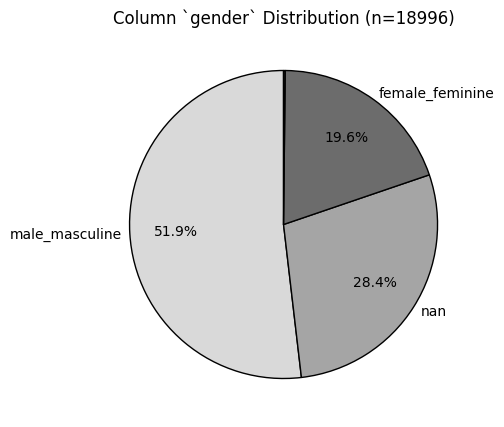

               gender  count  percent
0      male_masculine   9850    51.85
1                 NaN   5390    28.37
2     female_feminine   3724    19.60
3  do_not_wish_to_say     32     0.17


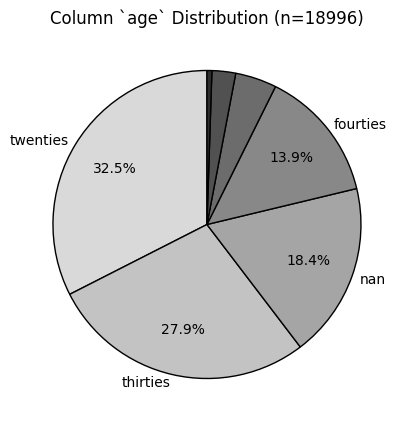

        age  count  percent
0  twenties   6172    32.49
1  thirties   5295    27.87
2       NaN   3493    18.39
3  fourties   2642    13.91
4   fifties    825     4.34
5     teens    472     2.48
6   sixties     97     0.51


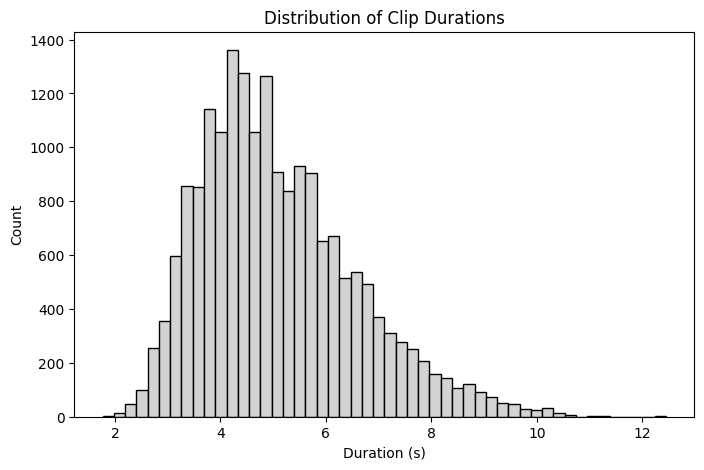

Summary statistics for duration[s]:
count    18996.000000
mean         5.098824
std          1.478732
min          1.764000
5%           3.096000
25%          3.996000
50%          4.860000
75%          5.976000
95%          7.920000
max         12.456000
Name: duration[s], dtype: float64
Total duration: 96857.25 seconds (26.90 hours)


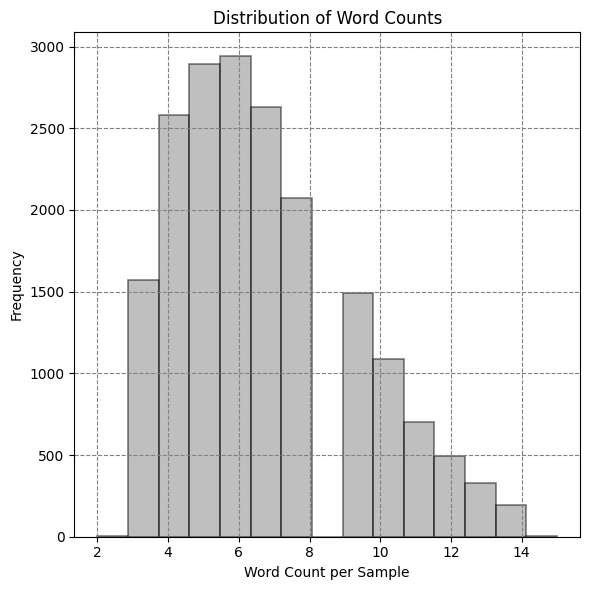


    Word statistics (Per Text):
        Total:      127182
        Unique:      31444
        Mean:         6.70
        STD:          2.56
        Median:       6.00
        Min:             2
        Max:            15
    


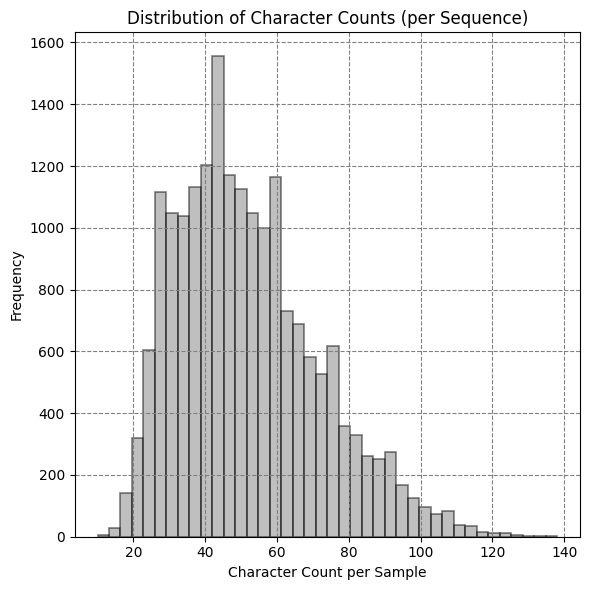


    Character statistics (Per Text):
        Total:      982196
        Mean:        51.71
        STD:         19.77
        Median:      49.00
        Min:            10
        Max:           138
    


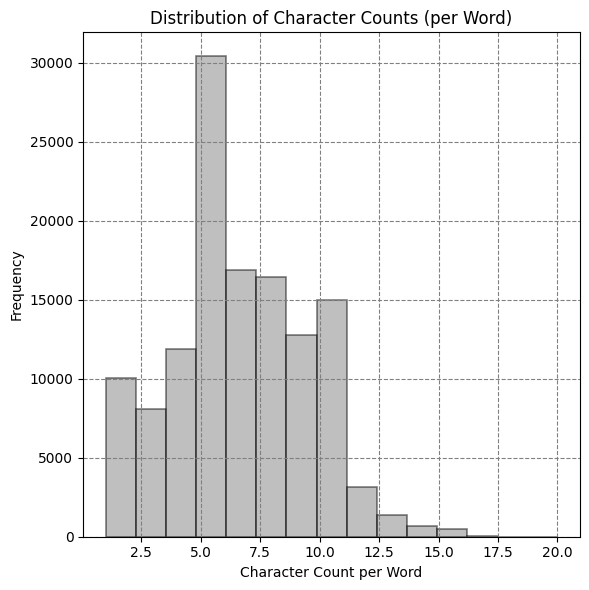


    Character statistics (Per Word):
        Total:      853299
        Mean:         6.71
        STD:          2.81
        Median:       7.00
        Min:             1
        Max:            20
    


In [10]:
# FULL DATASET
summarize_categorical_variable(df, column="gender")
summarize_categorical_variable(df, column="age")
summarize_duration(df)
summarize_sentences(df)

In [11]:
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    shuffle=True
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 17096
Test size: 1900


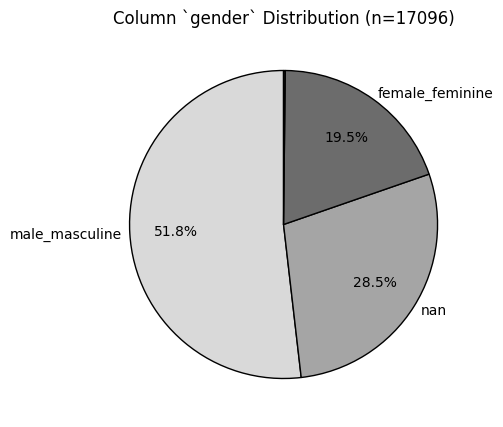

               gender  count  percent
0      male_masculine   8861    51.83
1                 NaN   4868    28.47
2     female_feminine   3338    19.53
3  do_not_wish_to_say     29     0.17


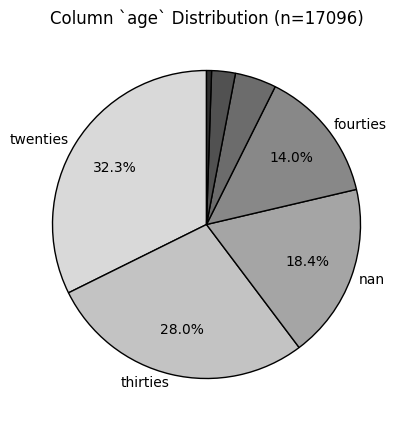

        age  count  percent
0  twenties   5525    32.32
1  thirties   4779    27.95
2       NaN   3144    18.39
3  fourties   2390    13.98
4   fifties    743     4.35
5     teens    425     2.49
6   sixties     90     0.53


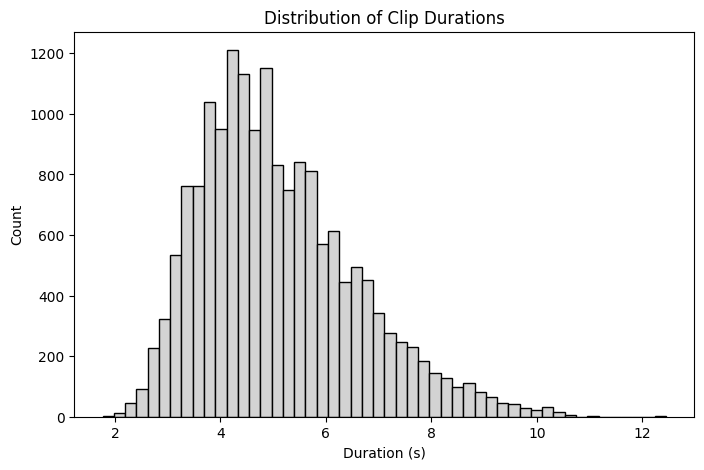

Summary statistics for duration[s]:
count    17096.000000
mean         5.102246
std          1.481260
min          1.764000
5%           3.096000
25%          3.996000
50%          4.860000
75%          5.976000
95%          7.920000
max         12.456000
Name: duration[s], dtype: float64
Total duration: 87228.00 seconds (24.23 hours)


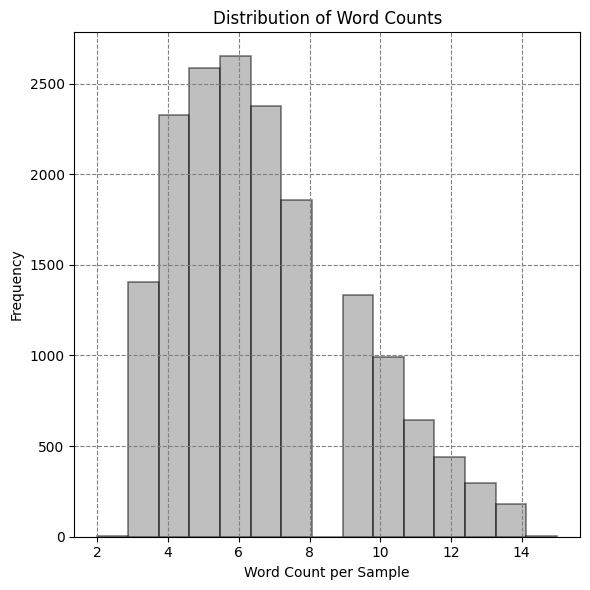


    Word statistics (Per Text):
        Total:      114574
        Unique:      29641
        Mean:         6.70
        STD:          2.56
        Median:       6.00
        Min:             2
        Max:            15
    


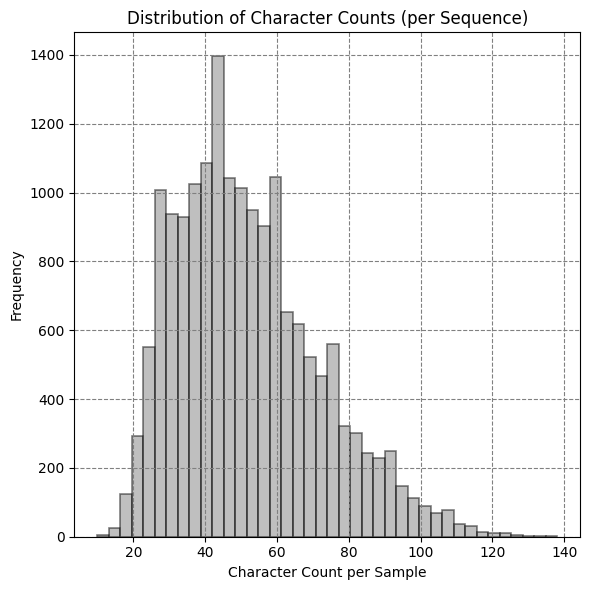


    Character statistics (Per Text):
        Total:      884322
        Mean:        51.73
        STD:         19.82
        Median:      49.00
        Min:            10
        Max:           138
    


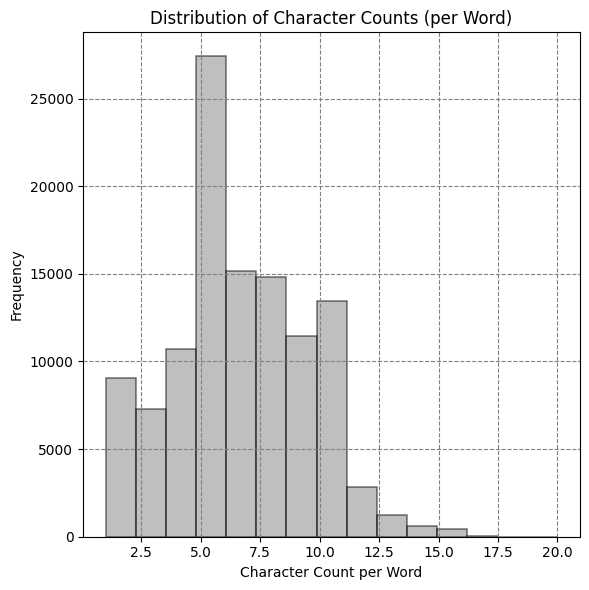


    Character statistics (Per Word):
        Total:      768241
        Mean:         6.71
        STD:          2.81
        Median:       7.00
        Min:             1
        Max:            20
    


In [12]:
# TRAINING SET
summarize_categorical_variable(train_df, column="gender")
summarize_categorical_variable(train_df, column="age")
summarize_duration(train_df)
summarize_sentences(train_df)

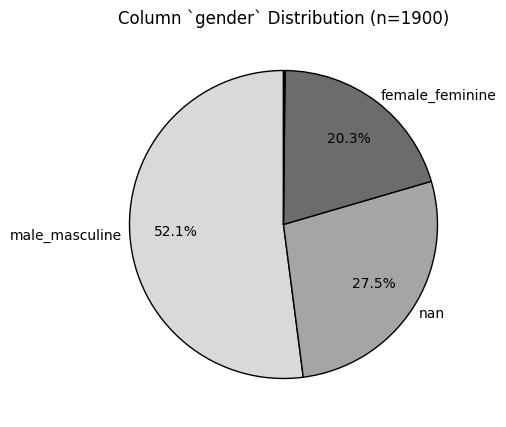

               gender  count  percent
0      male_masculine    989    52.05
1                 NaN    522    27.47
2     female_feminine    386    20.32
3  do_not_wish_to_say      3     0.16


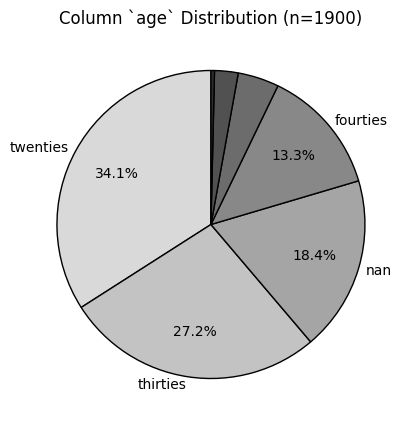

        age  count  percent
0  twenties    647    34.05
1  thirties    516    27.16
2       NaN    349    18.37
3  fourties    252    13.26
4   fifties     82     4.32
5     teens     47     2.47
6   sixties      7     0.37


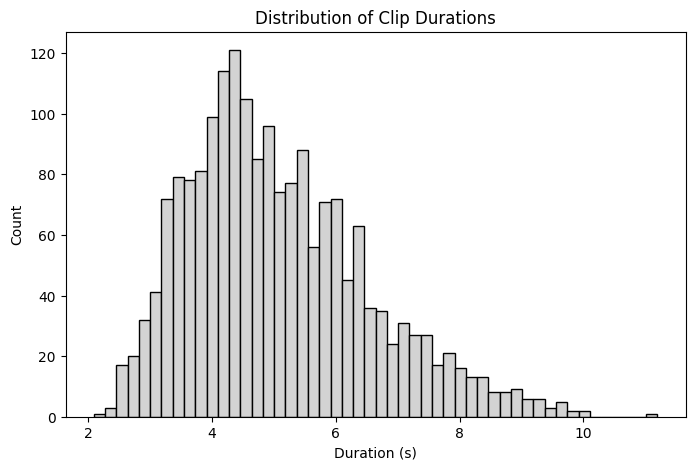

Summary statistics for duration[s]:
count    1900.000000
mean        5.068029
std         1.455809
min         2.088000
5%          3.096000
25%         3.996000
50%         4.824000
75%         5.940000
95%         7.848000
max        11.196000
Name: duration[s], dtype: float64
Total duration: 9629.26 seconds (2.67 hours)


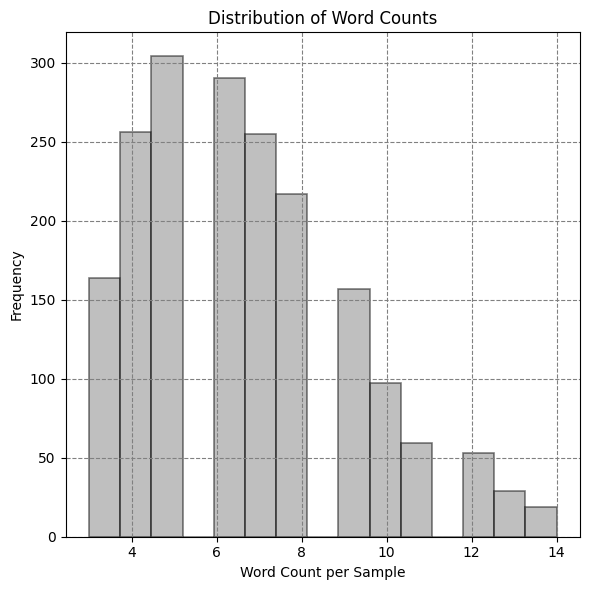


    Word statistics (Per Text):
        Total:       12608
        Unique:       6581
        Mean:         6.64
        STD:          2.53
        Median:       6.00
        Min:             3
        Max:            14
    


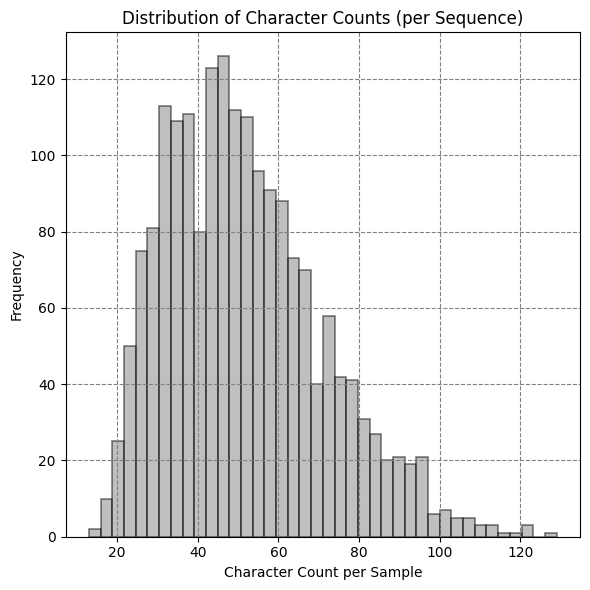


    Character statistics (Per Text):
        Total:       97874
        Mean:        51.51
        STD:         19.36
        Median:      49.00
        Min:            13
        Max:           129
    


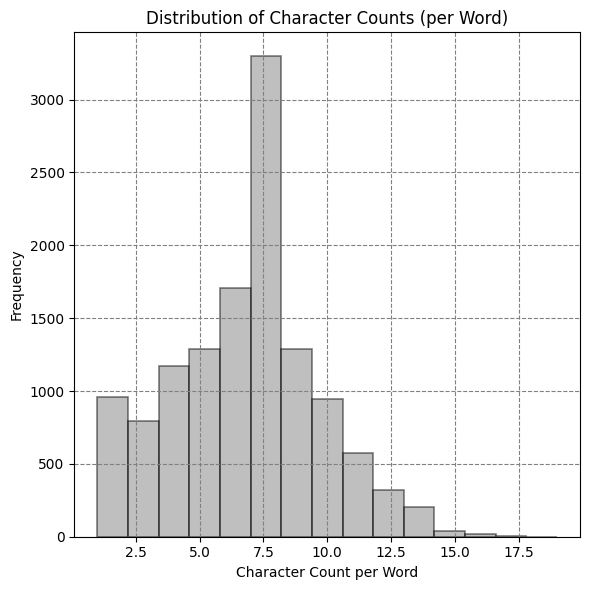


    Character statistics (Per Word):
        Total:       85058
        Mean:         6.75
        STD:          2.81
        Median:       7.00
        Min:             1
        Max:            19
    


In [13]:
# TESTING SET
summarize_categorical_variable(test_df, column="gender")
summarize_categorical_variable(test_df, column="age")
summarize_duration(test_df)
summarize_sentences(test_df)

In [14]:
def save_filelist(_df: pd.DataFrame, out_path: str) -> None:
    # Replace .mp3 with .wav in the paths
    paths = _df["path"].astype(str).str.replace(".mp3", ".wav", regex=False)
    lines = "files/cv_clips/" + paths + "|" + _df["sentence"].astype(str)
    Path(out_path).write_text("\n".join(lines), encoding="utf-8")
    print(f"Saved filelist to {out_path}")


save_filelist(train_df, "../files/cv_train.txt")
save_filelist(test_df, "../files/cv_test.txt")

Saved filelist to ../files/cv_train.txt
Saved filelist to ../files/cv_test.txt


In [15]:
clips_dir = cv_dataset_path / "clips"
out_dir = Path("../files/cv_clips")
out_dir.mkdir(parents=True, exist_ok=True)

target_sr = 16000
clip_paths = list(clips_dir.glob("*.mp3"))

for clip_path in tqdm(clip_paths, desc="Processing clips"):
    try:
        wav, sr = torchaudio.load(clip_path)

        if sr != target_sr:
            wav = torchaudio.transforms.Resample(orig_freq=sr, new_freq=target_sr)(wav)

        # save as wav with the same filename but in out_dir
        filepath = out_dir / (clip_path.stem + ".wav")
        torchaudio.save(filepath, wav, target_sr)

    except Exception as e:
        tqdm.write(f"Failed on {clip_path.name}: {e}")

print("All clips processed.")

Processing clips:   0%|          | 0/22619 [00:00<?, ?it/s]

All clips processed.
